In [1]:
!pip install pytorchcv

   ---------------------------------------- 0.0/532.4 kB ? eta -:--:--
   ---------------------------------------- 532.4/532.4 kB 5.7 MB/s eta 0:00:00


In [1]:
import torch
import torch.nn as nn

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 8

cifar_10_mean = (0.491, 0.482, 0.447)
cifar_10_std = (0.202, 0.199, 0.201)

mean = torch.tensor(cifar_10_mean).to(device).view(3, 1, 1)
std = torch.tensor(cifar_10_std).to(device).view(3, 1, 1)

epsilon = 8/255/std

alpha = 0.8/255/std

root = '../../Data/ml2021spring-hw10/data'

In [7]:
# Data
import os
import glob
import shutil
import numpy as np

from PIL import Image
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_10_mean, cifar_10_std)
])

In [6]:
class AdvDataset(Dataset):
    def __init__(self, data_dir, transform):
        self.images = []
        self.labels = []
        self.names = []

        for i, class_dir in enumerate(sorted(glob.glob(f'{data_dir}/*'))):
            images = sorted(glob.glob(f'{class_dir}/*'))
            self.images += images
            self.labels += ([i] * len(images))
            self.names += [os.path.relpath(imgs, data_dir) for imgs in images]
        self.tranform = transform

    def __getitem__(self, idx):
        image = self.tranform(Image.open(self.images[idx]))
        label = self.labels[idx]
        return image, label

    def __getname__(self):
        return self.names
    
    def __len__(self):
        return len(self.images)

In [8]:
adv_set = AdvDataset(root, transform=transform)
adv_names = adv_set.__getname__()
adv_loader = DataLoader(adv_set, batch_size=batch_size, shuffle=False)

In [9]:
print(f'number of images = {adv_set.__len__()}')

number of images = 200


In [ ]:
def epoch_benign(model, loader, loss_fn):
    # 将模型设置为评估模式
    model.eval()
    # 初始化训练准确率和训练损失
    train_acc, train_loss = 0.0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        yp = model(x)
        loss = loss_fn(yp, y)
        train_acc += (yp.argmax(dim=1) == y).sum().item()
        train_loss += loss.item() * x.shape[0]
    return train_acc / len(loader.dataset), train_loss / len(loader.dataset)

In [ ]:
# 定义FGSM函数，用于生成对抗样本
def fgsm(model, x, y, loss_fn, epsilon=epsilon):
    # 克隆输入数据，并设置requires_grad属性为True，以便计算梯度
    x_adv = x.detach().clone()
    x_adv.requires_grad = True
    # 计算损失函数
    loss = loss_fn(model(x_adv), y)
    # 反向传播，计算梯度
    loss.backward()

    # 根据梯度更新输入数据，生成对抗样本
    x_adv = x_adv + epsilon * x_adv.grad.detach().sign()
    # 返回生成的对抗样本
    return x_adv

In [ ]:
def gen_adv_examples(model, loader, attack, loss_fn):
    # 将模型设置为评估模式
    model.eval()
    # 初始化对抗样本名称列表
    adv_names = []
    # 初始化训练准确率和训练损失
    train_acc, train_loss = 0.0, 0.0
    # 遍历数据加载器
    for i, (x, y) in enumerate(loader):
        # 将输入数据和标签移动到指定设备
        x, y = x.to(device), y.to(device)
        x_adv = attack(model, x, y, loss_fn) # obtain adversarial examples
        yp = model(x_adv)
        loss = loss_fn(yp, y)
        train_acc += (yp.argmax(dim=1) == y).sum().item()
        train_loss += loss.item() * x.shape[0]
        # store adversarial examples
        adv_ex = ((x_adv) * std + mean).clamp(0, 1) # to 0-1 scale
        adv_ex = (adv_ex * 255).clamp(0, 255) # 0-255 scale
        adv_ex = adv_ex.detach().cpu().data.numpy().round() # round to remove decimal part
        adv_ex = adv_ex.transpose((0, 2, 3, 1)) # transpose (bs, C, H, W) back to (bs, H, W, C)
        adv_examples = adv_ex if i == 0 else np.r_[adv_examples, adv_ex]
    return adv_examples, train_acc / len(loader.dataset), train_loss / len(loader.dataset)


In [13]:
def create_dir(data_dir, adv_dir, adv_examples, adv_names):
    if os.path.exists(adv_dir) is not True:
        _ = shutil.copytree(data_dir, adv_dir)
    for example, name in zip(adv_examples, adv_names):
        im = Image.fromarray(example.astype(np.uint8)) # image pixel value should be unsigned int
        im.save(os.path.join(adv_dir, name))

In [14]:

from pytorchcv.model_provider import get_model as ptcv_get_model

model = ptcv_get_model('resnet110_cifar10', pretrained=True).to(device)
loss_fn = nn.CrossEntropyLoss()

benign_acc, benign_loss = epoch_benign(model, adv_loader, loss_fn)
print(f'benign_acc = {benign_acc:.5f}, benign_loss = {benign_loss:.5f}')

d:\anaconda3\envs\pytorch_env\lib\site-packages\pytorchcv\models\model_store.py:801: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_state = torch.load(file_path)


benign_acc = 0.95000, benign_loss = 0.22686


In [15]:
adv_examples, fgsm_acc, fgsm_loss = gen_adv_examples(model, adv_loader, fgsm, loss_fn)
print(f'fgsm_acc = {fgsm_acc:.5f}, fgsm_loss = {fgsm_loss:.5f}')

create_dir(root, 'fgsm', adv_examples, adv_names)
     

fgsm_acc = 0.60000, fgsm_loss = 2.46301


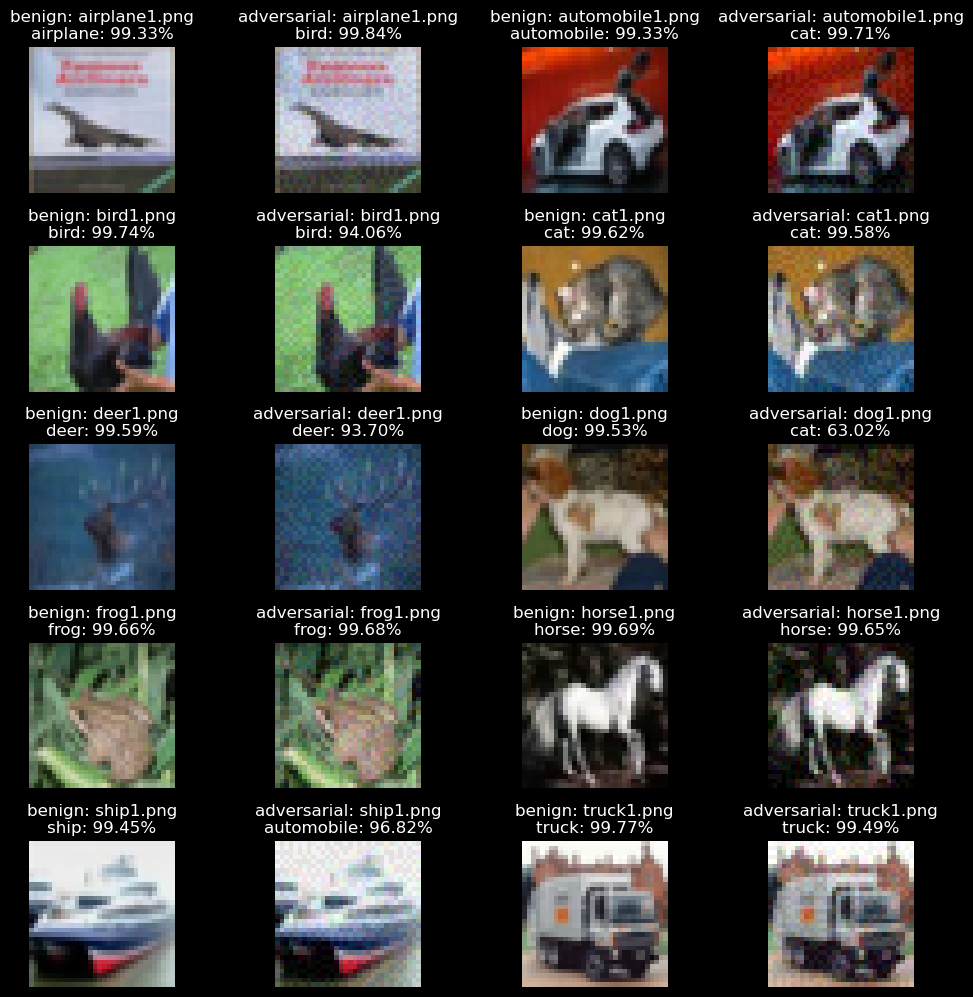

In [17]:

import matplotlib.pyplot as plt

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 20))
cnt = 0
for i, cls_name in enumerate(classes):
    path = f'{cls_name}/{cls_name}1.png'
    # benign image
    cnt += 1
    plt.subplot(len(classes), 4, cnt)
    im = Image.open(f'../../Data/ml2021spring-hw10/data/{path}')
    logit = model(transform(im).unsqueeze(0).to(device))[0]
    predict = logit.argmax(-1).item()
    prob = logit.softmax(-1)[predict].item()
    plt.title(f'benign: {cls_name}1.png\n{classes[predict]}: {prob:.2%}')
    plt.axis('off')
    plt.imshow(np.array(im))
    # adversarial image
    cnt += 1
    plt.subplot(len(classes), 4, cnt)
    im = Image.open(f'./fgsm/{path}')
    logit = model(transform(im).unsqueeze(0).to(device))[0]
    predict = logit.argmax(-1).item()
    prob = logit.softmax(-1)[predict].item()
    plt.title(f'adversarial: {cls_name}1.png\n{classes[predict]}: {prob:.2%}')
    plt.axis('off')
    plt.imshow(np.array(im))
plt.tight_layout()
plt.show()
     